In [33]:
from time import time
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime, timedelta
import ensemble_kalman_filter as enkf
import os

In [34]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.style.use("default")
plt.rcParams["font.size"] = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
model_name = 'lorenz96'
save_flag = True
save_dir ='../dataset/'+ model_name +'/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [36]:
def rk4_step(y, i, dt, f):
    h = dt
    t = dt * i
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, dt * i + h / 2)
    k3 = h * f(y + k2 / 2, t + h / 2)
    k4 = h * f(y + k3, t + h)

    y_next = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

    

@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        ysi = rk4_step(ys[i - 1], i, dt, f)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

(5000, 3)


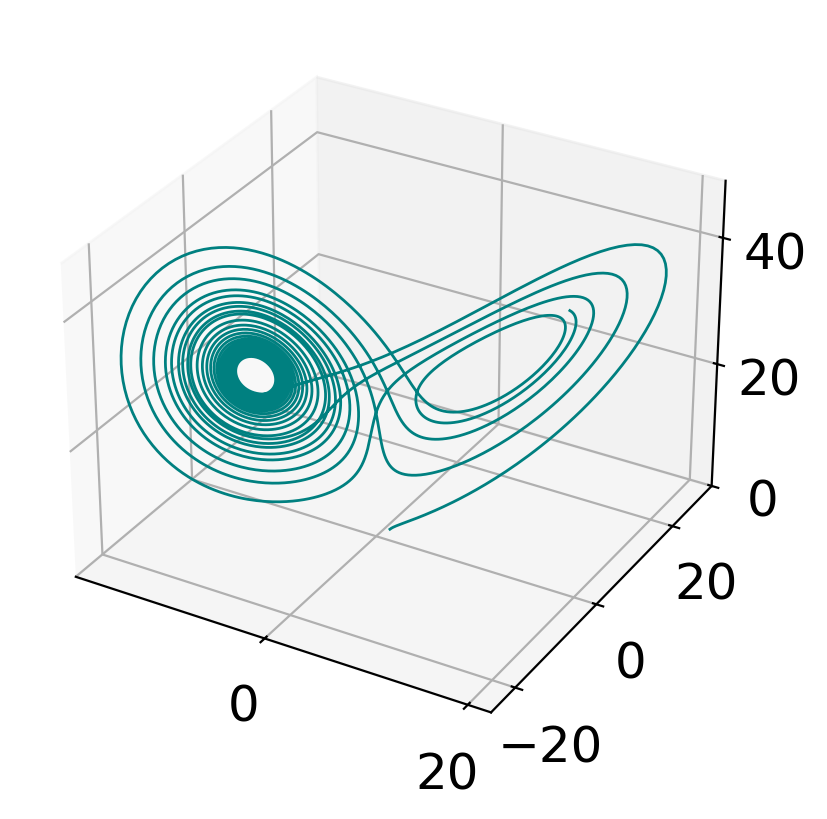

In [37]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t):
    x, y, z = state
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return jnp.array([xdot, ydot, zdot])

y0 = jnp.ones(3)
N = 5000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*res.T, lw=1.0, c="teal")
print(res.shape)

$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$


In [38]:
D = 72
F = 8.0
# ixs = jnp.arange(D)
# save_dir ='./dataset/lorenz96_' + str(D) + '/'

key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval = jax.random.split(key, 3)
x0 = jax.random.normal(key_init, (D,)) + F

key_state, key_measurement = jax.random.split(key_sim)

@partial(jax.vmap, in_axes=(None, 0, None))
def fcoord(x, k, D):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, D, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    ixs = jnp.arange(D)
    xdot = fcoord(x, ixs, D) + F + err
    return xdot

In [39]:
N = 20000
dt = 0.01
corrupted = True
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
fpart = partial(f, D=D)
xs = rk4(xs, dt, N, fpart)
ys = xs + jax.random.normal(key_measurement, xs.shape)

In [40]:
ys_corrupted = ys.copy()
if corrupted:
    p_err = 0.01
    errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys_corrupted.shape)
    ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
    err_where = np.where(errs_map)

In [41]:
print('xs', xs.shape)
print('ys', ys.shape)
print(x0.shape)
print('ys_corrupted', ys_corrupted.shape)

xs (20000, 72)
ys (20000, 72)
(72,)
ys_corrupted (20000, 72)


In [42]:
# 生成时间序列
start_time = datetime(2024, 6, 7, 13, 0, 0)
time_interval = timedelta(seconds=1)
time_series = [start_time + i * time_interval for i in range(xs.shape[0])]

# 创建 DataFrame
column_names = [f'x_{i}' for i in range(1, xs.shape[1] + 1)]
df = pd.DataFrame(xs, columns=column_names)
df.insert(0, 'date', time_series)

print(df.head())

                 date       x_1       x_2       x_3       x_4       x_5  \
0 2024-06-07 13:00:00  7.101736  8.169513  7.512361  8.391337  8.156775   
1 2024-06-07 13:00:01  7.200568  8.279476  7.712861  8.477451  8.366982   
2 2024-06-07 13:00:02  7.301495  8.406007  7.911992  8.568678  8.544809   
3 2024-06-07 13:00:03  7.407736  8.549021  8.109913  8.661312  8.688896   
4 2024-06-07 13:00:04  7.522329  8.708394  8.306170  8.751287  8.797832   

        x_6       x_7       x_8       x_9  ...      x_63      x_64      x_65  \
0  9.290910  5.568867  6.880819  7.574549  ...  9.253570  7.115378  7.356079   
1  9.123447  5.553490  6.898337  7.839458  ...  9.373565  7.225134  7.348793   
2  8.942765  5.525872  6.940490  8.115047  ...  9.495525  7.312145  7.331226   
3  8.748513  5.492054  7.008259  8.402708  ...  9.616627  7.374304  7.303985   
4  8.541310  5.457930  7.102516  8.703338  ...  9.733598  7.409505  7.268179   

       x_66      x_67      x_68      x_69      x_70      x_71      x

In [43]:
if save_flag:
    # # 保存为 CSV 文件
    csv_path = save_dir + model_name + '.csv'
    df.to_csv(csv_path, index=False)
    # 创建 DataFrame
    column_names = [f'y_{i}' for i in range(1, ys.shape[1] + 1)]
    dfy = pd.DataFrame(ys, columns=column_names)
    dfy.insert(0, 'date', time_series)

    print(dfy.head())
    csv_path = save_dir + model_name + '_obs.csv'
    dfy.to_csv(csv_path, index=False)

    column_names = [f'y_{i}' for i in range(1, ys_corrupted.shape[1] + 1)]
    dfy = pd.DataFrame(ys_corrupted, columns=column_names)
    dfy.insert(0, 'date', time_series)

    print(dfy.head())
    csv_path = save_dir + model_name + '_obs_corrupted.csv'
    dfy.to_csv(csv_path, index=False)

                 date       y_1       y_2       y_3       y_4       y_5  \
0 2024-06-07 13:00:00  7.870437  8.889256  7.929803  8.424289  6.538892   
1 2024-06-07 13:00:01  6.306410  7.234029  6.845594  9.969914  9.018757   
2 2024-06-07 13:00:02  6.154200  9.539615  9.229718  7.963217  7.750986   
3 2024-06-07 13:00:03  6.907467  9.668764  7.491506  7.968972  7.310291   
4 2024-06-07 13:00:04  8.448561  9.880724  7.995170  8.215715  7.582194   

         y_6       y_7       y_8       y_9  ...       y_63      y_64  \
0   9.131293  3.754496  6.996747  8.300844  ...   9.651628  5.907339   
1  10.129133  7.311955  6.889918  5.814001  ...   7.098639  5.971278   
2   8.404692  5.329862  6.484908  9.243864  ...   9.604142  6.361812   
3   9.154658  5.965530  6.792809  8.031495  ...   9.697099  7.734292   
4   9.128675  3.852144  6.669165  8.485173  ...  10.878561  6.578136   

       y_65      y_66      y_67      y_68      y_69      y_70      y_71  \
0  7.698168  7.286294  6.394009  9.136106

In [44]:
range_time = np.arange(N) * dt
np.set_printoptions(precision=4)
def callback_fn(particles, particles_pred, y, i):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean()), particles.mean(axis=0)
def latent_fn(x, key, i):
    """
    State function
    """
    err = jax.random.normal(key, (D,))
    @jax.jit
    def f(x, t):
        ixs = jnp.arange(D)
        return fcoord(x, ixs, D) + F + err
    
    return rk4_step(x, i, dt, f)


def obs_fn(x, key, i):
    """
    Measurement function
    """
    err = jax.random.normal(key, (D,))
    return x + err
def calculate_mse(errs):
    return jnp.mean(jnp.square(errs))
def calculate_mae(errs):
    return jnp.mean(jnp.abs(errs))

def calculate_rmse(errs):
    return jnp.sqrt(jnp.mean(jnp.square(errs)))

def calculate_test_error(errs):
    mse = calculate_mse(errs)
    mae = calculate_mae(errs)
    rmse = calculate_rmse(errs) 
    print(f'mse:{mse}, mae:{mae}, rmse:{rmse}')
    return mse, mae, rmse


In [45]:
# y_index = int(0.8 * ys.shape[0])
# print(ys.shape)
# # 截取最后 20% 的数据
# ys = ys[y_index:]
# ys_corrupted = ys_corrupted[y_index:]
# print(ys.shape)

In [46]:
method = 'EnKF_20'
n_particles = 20
agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
key_init_particles, key_scan = jax.random.split(key_eval, 2)
X0 = agent.init_bel(key_init_particles, D)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
errs_index = int(0.8 * errs.shape[0])
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys_corrupted, callback_fn=callback_fn)
tend = time()
time_cost = (tend - tinit) / 0.2 / N * 1000
print('corrupted')
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)

mse:nan, mae:nan, rmse:nan
time cost (ms): 0.7053561210632324
corrupted
mse:nan, mae:nan, rmse:nan
time cost (ms): 0.21793395280838013


In [47]:
method = 'EnKF_1000'
n_particles = 1000
agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
key_init_particles, key_scan = jax.random.split(key_eval, 2)
X0 = agent.init_bel(key_init_particles, D)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys_corrupted, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
print('corrupted')
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)

mse:64.45046997070312, mae:7.984593868255615, rmse:8.028104782104492
time cost (ms): 0.8003659248352051
corrupted
mse:72.30783081054688, mae:8.470747947692871, rmse:8.503400802612305
time cost (ms): 1.040771484375


In [48]:
method = 'EnKFI_20_3'
n_particles = 20
inflation_factor = 3.0
agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
key_init_particles, key_scan = jax.random.split(key_eval, 2)
X0 = agent.init_bel(key_init_particles, D)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys_corrupted, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
print('corrupted')
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)

mse:0.45361119508743286, mae:0.6698382496833801, rmse:0.6735066175460815
time cost (ms): 0.8855264186859131
corrupted
mse:42.394405364990234, mae:5.904505729675293, rmse:6.511098861694336
time cost (ms): 0.9013922214508057


In [49]:
method = 'EnKFI_1000_3'
n_particles = 1000
inflation_factor = 3.0
agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
key_init_particles, key_scan = jax.random.split(key_eval, 2)
X0 = agent.init_bel(key_init_particles, D)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys_corrupted, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
print('corrupted')
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)

mse:0.3142666220664978, mae:0.5586151480674744, rmse:0.5605948567390442
time cost (ms): 0.7531294822692871
corrupted
mse:31.829120635986328, mae:4.972006320953369, rmse:5.641730308532715
time cost (ms): 0.9029171466827393


In [50]:
# n_particles = 20
# inflation_factor = 3.0
# agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# # agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
# key_init_particles, key_scan = jax.random.split(key_eval, 2)
# X0 = agent.init_bel(key_init_particles, D)
# tinit = time()
# particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
# tend = time()
# time_cost = tend - tinit
# calculate_test_error(errs)

In [51]:
# n_particles = 1000
# inflation_factor = 3.0
# agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# # agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
# key_init_particles, key_scan = jax.random.split(key_eval, 2)
# X0 = agent.init_bel(key_init_particles, D)
# tinit = time()
# particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
# tend = time()
# time_cost = tend - tinit
# calculate_test_error(errs)